In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
#read all images from the folder
def read_images(folder):
    images = {}
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images[filename.split('.')[0]] = img
    return images

In [3]:
folder = 'test_images_skincancer'

In [4]:
images = read_images(folder)

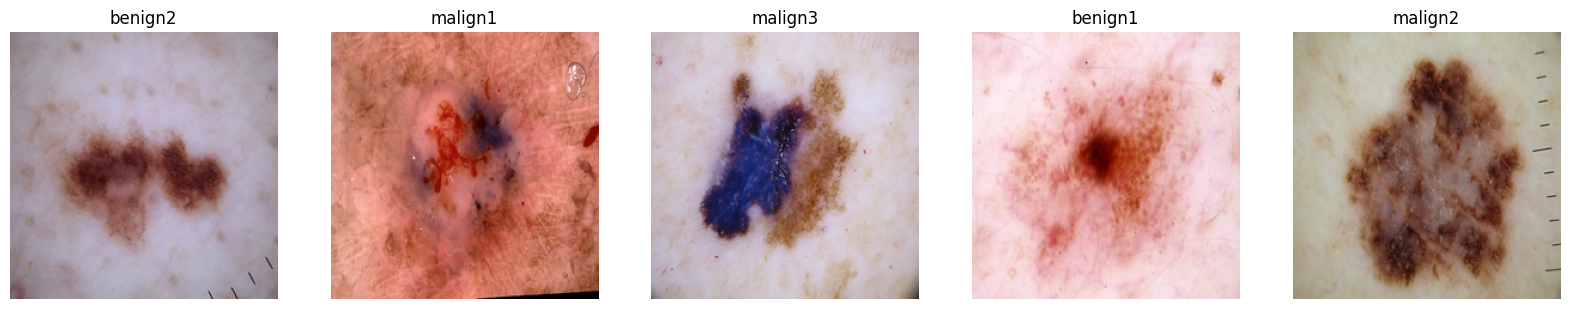

In [27]:
# plot the images
fig, axes = plt.subplots(1, len(images), figsize=(20, 20))
for ax, (name, img) in zip(axes, images.items()):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(name)
plt.show()

In [28]:
def pca_img(img):
    # create a dataframe in which each row is a pixel, the first three columns are the RGB values, the for each neighborhood pixel, we add the three RGB values
    # the neighborhood is defined as the 8 pixels around the pixel
    df = pd.DataFrame(img.reshape(-1, 3), columns=['R', 'G', 'B'])
    # add the 8 neighbors
    for i in range(1, 9):
        df[f'R{i}'] = df['R'].shift(i)
        df[f'G{i}'] = df['G'].shift(i)
        df[f'B{i}'] = df['B'].shift(i)
    #df = df.dropna()
    #fill NaN with forward fill
    df = df.ffill()
    #fill NaN with backward fill
    df = df.bfill()
    # apply standardization to the dataframe
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
    # apply PCA to the dataframe
    pca = PCA(n_components=5)
    df_pca = pca.fit_transform(df_scaled)
    # create a new dataframe with the principal components
    df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
    df_pca.head()
    # normalize between 0 and 1
    df_pca = (df_pca - df_pca.min()) / (df_pca.max() - df_pca.min())
    matrix_pca1 = df_pca['PC1'].values.reshape(img.shape[0], img.shape[1])
    matrix_pca2 = df_pca['PC2'].values.reshape(img.shape[0], img.shape[1])
    matrix_pca3 = df_pca['PC3'].values.reshape(img.shape[0], img.shape[1])
    matrix_pca4 = df_pca['PC4'].values.reshape(img.shape[0], img.shape[1])
    matrix_pca5 = df_pca['PC5'].values.reshape(img.shape[0], img.shape[1])

    return (matrix_pca1, matrix_pca2, matrix_pca3, matrix_pca4, matrix_pca5), pca.explained_variance_ratio_ * 100

In [29]:
# apply PCA to the images
images_pca = {}
for name, img in images.items():
    matrices, explained_var_scores = pca_img(np.array(img))
    images_pca[name] = (matrices, explained_var_scores, images[name])

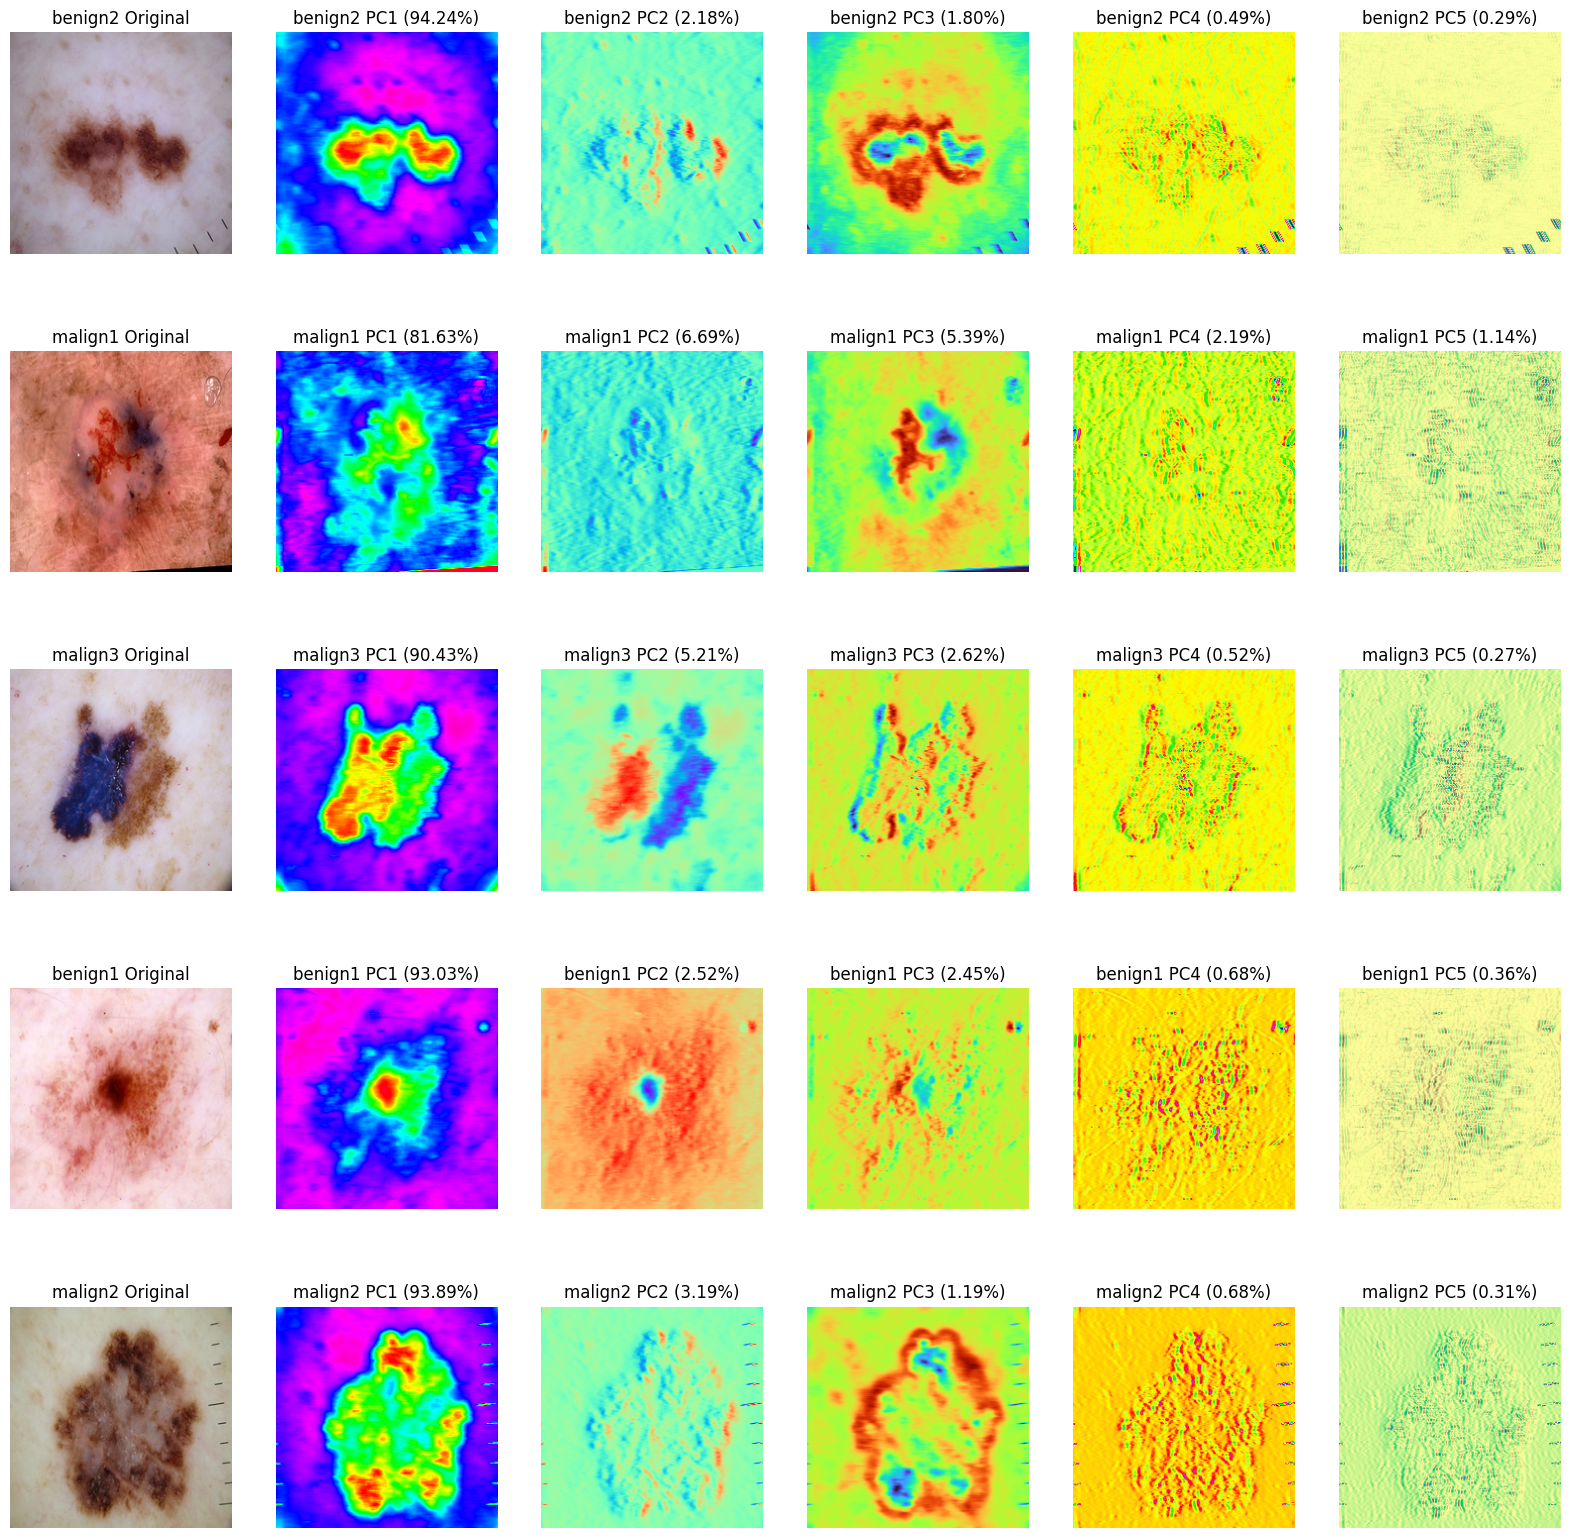

In [46]:
# plot the new image
fig, ax = plt.subplots(5, 6, figsize=(20, 20))
colors = ['gist_rainbow', 'rainbow', 'turbo', 'gist_ncar', 'terrain']
for i, (name, (matrices, scores, original)) in enumerate(images_pca.items()):
    ax[i, 0].imshow(original)
    ax[i, 0].axis('off')
    ax[i, 0].set_title(name + ' Original')
    for j, matrix in enumerate(matrices):
        ax[i, j+1].imshow(matrix, cmap=colors[j])
        ax[i, j+1].axis('off')
        ax[i, j+1].set_title(f'{name} PC{j+1} ({scores[j]:.2f}%)')